# Merge Process

---

## 1. Set Environment

In [1]:
import os

# Load API Keys
from config.secret_keys import OPENAI_API_KEY, USER_AGENT, TAVILY_API_KEY

os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['USER_AGENT'] = USER_AGENT

## 2. Import Modules

In [8]:
# directory setting
from pathlib import Path

# Define State
from typing import Annotated, List, Literal
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# Define Nodes
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Define Agent
from langchain_openai import ChatOpenAI

# Define Edges
from langgraph.checkpoint.memory import MemorySaver

# Build Graph
from langgraph.graph import START, END, StateGraph

## 3. Processes

### 3-1. Define State

In [3]:
class State(TypedDict):
    """
    Represents the state of graph.

    Args:
        question : question that user ask
        generation : LLM generation
        documents : list of documents
    """
    question : str
    generation : str
    messages : Annotated[list, add_messages]
    documents : List[str]

### 3-2. Writer

In [15]:
# writer node
from finpilot.writer import retrieve_node, write_node, filter_documents_node, transform_query_node, web_search_node
# writer edge function
from finpilot.writer import decide_write_or_rewrite_query, decide_to_retrieve_or_web_search, decide_to_regenerate_or_rewrite_query_or_end

c:\Users\USER\anaconda3\envs\finpilot\lib\site-packages\langsmith\client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [5]:
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("retriever", retrieve_node)
workflow.add_node("filter_documents", filter_documents_node)
workflow.add_node("writer", write_node)
workflow.add_node("transform_query", transform_query_node)
workflow.add_node("web_search", web_search_node)

# connects edges
workflow.add_edge(START, "retriever")
workflow.add_edge("retriever", "filter_documents")
workflow.add_conditional_edges(
    "filter_documents",
    decide_write_or_rewrite_query,
    {
        "writer" : "writer",
        "transform_query" : "transform_query"
    },
)
workflow.add_conditional_edges(
    "transform_query",
    decide_to_retrieve_or_web_search,
    {
        "retriever" : "retriever",
        "web_search" : "web_search"
    }
)
workflow.add_edge("web_search", "writer")
workflow.add_conditional_edges(
    "writer",
    decide_to_regenerate_or_rewrite_query_or_end,
    {
        "not supported" : "writer",
        "useful" : END,
        "not useful" : "transform_query"
    }
)

app = workflow.compile()

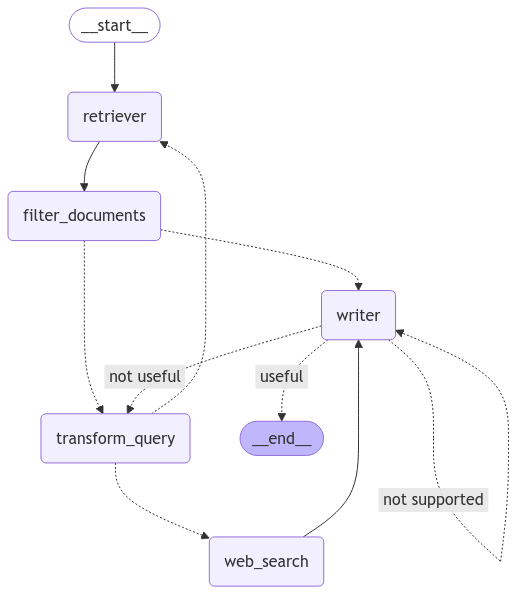

In [6]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
# Run
inputs = {"question": "코스피와 코스닥에 대한 최근 이슈에 대한 인사이트를 작성해줘"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
print(value["generation"])

[Graph Log] RETRIEVE ...


c:\SKN05-FINAL-3TEAM\model\finpilot\vectorstore.py:36: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


Node 'retriever':

---

[Graph Log] FILTER DOCUMENTS ...
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Graph Log] DETERMINES 'WRITE' OR 'REWRITE QUESTION' ...
[Graph Log] DECISION : REWRITE QUESTION
Node 'filter_documents':

---

[Graph Log] TRANSFORM QUERY ...
[Graph Log] DETERMINES 'RETRIEVE' OR 'WEB SEARCH' ...
[Graph Log] DECISION : WEB SEARCH
Node 'transform_query':

---

[Graph Log] WEB SEARCH ...
Node 'web_search':

---

[Graph Log] WRITE ...
[Graph Log] CHECK HALLUCINATIONS ...
[Graph Log] DECISION : ANSWER IS GROUNDED IN DOCUMENTS
[Graph Log] CHECK ANSWER IS USEFUL OR NOT ...
[Graph Log] DECISION : GENERATION ADDRESSES QUESTION
Node 'writer':

---

최근 코스피는 외국인과 기관투자자의 매수 덕분에 2440선을 회복하며 2444.70을 기록하고 있습니다. 코스닥 지수는 700선을 탈환하며 700.40에 도달했으며, 기관의 매수세가 두드러집니다. 전반적으로 국내 증시는 상승세를 보이고 있습니다.


In [8]:
print(value["messages"])
print(len(value["messages"]))

[HumanMessage(content='최근 코스피와 코스닥의 주요 이슈 및 동향에 대한 인사이트를 제공해줄 수 있나요?', additional_kwargs={}, response_metadata={}, id='bc094088-c0d1-4f44-a78a-0e99505eade1'), AIMessage(content='최근 코스피는 외국인과 기관투자자의 매수 덕분에 2440선을 회복하며 2444.70을 기록하고 있습니다. 코스닥 지수는 700선을 탈환하며 700.40에 도달했으며, 기관의 매수세가 두드러집니다. 전반적으로 국내 증시는 상승세를 보이고 있습니다.', additional_kwargs={}, response_metadata={}, id='00171257-a472-4e3d-bac1-fe30e193dcdc')]
2


### 3-3. Text Magician

In [16]:
from finpilot.text_magician import text_magician_node

In [5]:
workflow = StateGraph(State)

# Add Nodes
workflow.add_node("text_magician", text_magician_node)

# Add Edges
workflow.add_edge(START, "text_magician")
workflow.add_edge("text_magician", END)

app = workflow.compile()

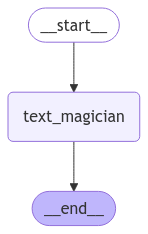

In [6]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [7]:
inputs = {"question" : """
    최근 코스피는 외국인과 기관투자자의 매수 덕분에 2440선을 회복하며 2444.70을 기록했습니다. 코스닥 지수는 장중 2% 상승하여 700선을 탈환했습니다. 전반적으로 국내 증시는 상승세를 보이고 있습니다
    
    이 텍스트를 확장해줘
"""}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
print(value["generation"])

[Graph Log] TEXT_MAGICIAN ...
Node 'text_magician':

---

최근 한국의 주식 시장에서 긍정적인 흐름이 이어지고 있습니다. 코스피 지수는 외국인과 기관투자자들의 활발한 매수세에 힘입어 2440선을 회복하며 2444.70을 기록했습니다. 이는 투자자들의 신뢰가 회복되고 있다는 신호로 해석될 수 있습니다. 외국인 투자자들은 특히 대형주에 대한 관심을 보이며, 안정적인 수익을 추구하는 경향이 강해지고 있습니다.

한편, 코스닥 지수 또한 장중 2% 상승하며 700선을 탈환했습니다. 이는 기술주와 중소형주들이 강세를 보인 결과로, 투자자들은 성장 가능성이 높은 기업들에 대한 관심을 더욱 높이고 있는 것으로 보입니다. 이러한 상승세는 글로벌 경제의 회복세와 함께 국내 기업들의 실적 개선 기대감이 반영된 결과일 수 있습니다.

전반적으로 국내 증시는 상승세를 보이며, 시장의 분위기가 긍정적으로 전환되고 있습니다. 전문가들은 이러한 흐름이 지속될 가능성이 있다고 전망하며, 투자자들에게는 보다 신중한 접근이 필요하다고 조언하고 있습니다. 특히, 글로벌 경제 상황이나 금리 변화 등 외부 요인에 대한 모니터링이 중요하다는 점을 강조하고 있습니다. 

이와 함께, 투자자들은 각종 경제 지표와 기업 실적 발표를 주의 깊게 살펴보아야 하며, 시장의 변동성에 대비한 전략을 세우는 것이 필요할 것입니다. 이러한 시장 상황 속에서, 투자자들은 보다 다양한 투자 기회를 모색할 수 있을 것으로 기대됩니다.


In [8]:
print(value["messages"])
print(len(value["messages"]))

[HumanMessage(content='\n    최근 코스피는 외국인과 기관투자자의 매수 덕분에 2440선을 회복하며 2444.70을 기록했습니다. 코스닥 지수는 장중 2% 상승하여 700선을 탈환했습니다. 전반적으로 국내 증시는 상승세를 보이고 있습니다\n    \n    이 텍스트를 확장해줘\n', additional_kwargs={}, response_metadata={}, id='1b9daa70-78d1-4b92-bfe9-f547a5b3b164'), AIMessage(content='최근 한국의 주식 시장에서 긍정적인 흐름이 이어지고 있습니다. 코스피 지수는 외국인과 기관투자자들의 활발한 매수세에 힘입어 2440선을 회복하며 2444.70을 기록했습니다. 이는 투자자들의 신뢰가 회복되고 있다는 신호로 해석될 수 있습니다. 외국인 투자자들은 특히 대형주에 대한 관심을 보이며, 안정적인 수익을 추구하는 경향이 강해지고 있습니다.\n\n한편, 코스닥 지수 또한 장중 2% 상승하며 700선을 탈환했습니다. 이는 기술주와 중소형주들이 강세를 보인 결과로, 투자자들은 성장 가능성이 높은 기업들에 대한 관심을 더욱 높이고 있는 것으로 보입니다. 이러한 상승세는 글로벌 경제의 회복세와 함께 국내 기업들의 실적 개선 기대감이 반영된 결과일 수 있습니다.\n\n전반적으로 국내 증시는 상승세를 보이며, 시장의 분위기가 긍정적으로 전환되고 있습니다. 전문가들은 이러한 흐름이 지속될 가능성이 있다고 전망하며, 투자자들에게는 보다 신중한 접근이 필요하다고 조언하고 있습니다. 특히, 글로벌 경제 상황이나 금리 변화 등 외부 요인에 대한 모니터링이 중요하다는 점을 강조하고 있습니다. \n\n이와 함께, 투자자들은 각종 경제 지표와 기업 실적 발표를 주의 깊게 살펴보아야 하며, 시장의 변동성에 대비한 전략을 세우는 것이 필요할 것입니다. 이러한 시장 상황 속에서, 투자자들은 보다 다양한 투자 기회를 모색할 수 있을 것으로 기대됩니다.', additional_kwargs={}, r

In [9]:
texts = """
최근 한국의 주식 시장은 외국인 투자자와 기관 투자자들의 활발한 매수세 덕분에 긍정적인 흐름을 보이고 있습니다. 특히 코스피 지수는 2440선을 회복하며 2444.70을 기록했습니다. 이는 투자자들의 신뢰가 회복되고 있다는 신호로 해석될 수 있습니다. 외국인과 기관의 매수는 시장에 유동성을 공급하고, 이는 주가 상승에 긍정적인 영향을 미치고 있습니다.

코스닥 지수 또한 장중 2% 상승하여 700선을 탈환하는 성과를 올렸습니다. 코스닥 시장의 상승은 기술주 및 중소형주에 대한 투자 심리가 개선되었음을 나타내며, 이는 전체 시장에 긍정적인 영향을 미치는 요소로 작용하고 있습니다. 투자자들은 기업 실적 개선, 글로벌 경제 회복, 그리고 정부의 정책 지원 등 다양한 긍정적인 요인들을 반영하여 적극적으로 매수에 나서고 있는 것으로 보입니다.

전반적으로 국내 증시는 상승세를 보이며 투자자들의 기대감을 높이고 있습니다. 이러한 상승세는 앞으로의 경제 전망에 대한 긍정적인 신호로 해석될 수 있으며, 앞으로도 외국인과 기관의 지속적인 매수가 이어질 경우, 시장의 추가 상승 가능성도 열려 있습니다. 따라서 투자자들은 시장의 흐름을 주의 깊게 살펴보며, 적절한 투자 전략을 세우는 것이 중요할 것으로 보입니다.
"""

inputs = {"question" : texts + "\n 이 내용을 요약해줘"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
print(value["generation"])

[Graph Log] TEXT_MAGICIAN ...
Node 'text_magician':

---

최근 한국 주식 시장은 외국인 및 기관 투자자들의 활발한 매수세 덕분에 긍정적인 흐름을 보이고 있습니다. 코스피 지수는 2440선을 회복하며 2444.70을 기록했고, 코스닥 지수는 2% 상승하여 700선을 탈환했습니다. 이는 투자자들의 신뢰 회복과 기술주 및 중소형주에 대한 긍정적인 투자 심리를 반영합니다. 기업 실적 개선, 글로벌 경제 회복, 정부의 정책 지원 등이 매수에 긍정적인 영향을 미치고 있으며, 이러한 상승세는 앞으로의 경제 전망에 대한 기대감을 높이고 있습니다. 따라서 투자자들은 시장 흐름을 주의 깊게 살펴보며 적절한 투자 전략을 세우는 것이 중요합니다.


In [10]:
print(value["messages"])
print(len(value["messages"]))

[HumanMessage(content='\n최근 한국의 주식 시장은 외국인 투자자와 기관 투자자들의 활발한 매수세 덕분에 긍정적인 흐름을 보이고 있습니다. 특히 코스피 지수는 2440선을 회복하며 2444.70을 기록했습니다. 이는 투자자들의 신뢰가 회복되고 있다는 신호로 해석될 수 있습니다. 외국인과 기관의 매수는 시장에 유동성을 공급하고, 이는 주가 상승에 긍정적인 영향을 미치고 있습니다.\n\n코스닥 지수 또한 장중 2% 상승하여 700선을 탈환하는 성과를 올렸습니다. 코스닥 시장의 상승은 기술주 및 중소형주에 대한 투자 심리가 개선되었음을 나타내며, 이는 전체 시장에 긍정적인 영향을 미치는 요소로 작용하고 있습니다. 투자자들은 기업 실적 개선, 글로벌 경제 회복, 그리고 정부의 정책 지원 등 다양한 긍정적인 요인들을 반영하여 적극적으로 매수에 나서고 있는 것으로 보입니다.\n\n전반적으로 국내 증시는 상승세를 보이며 투자자들의 기대감을 높이고 있습니다. 이러한 상승세는 앞으로의 경제 전망에 대한 긍정적인 신호로 해석될 수 있으며, 앞으로도 외국인과 기관의 지속적인 매수가 이어질 경우, 시장의 추가 상승 가능성도 열려 있습니다. 따라서 투자자들은 시장의 흐름을 주의 깊게 살펴보며, 적절한 투자 전략을 세우는 것이 중요할 것으로 보입니다.\n\n 이 내용을 요약해줘', additional_kwargs={}, response_metadata={}, id='944002e9-e76c-4c07-994c-eb95de1e9689'), AIMessage(content='최근 한국 주식 시장은 외국인 및 기관 투자자들의 활발한 매수세 덕분에 긍정적인 흐름을 보이고 있습니다. 코스피 지수는 2440선을 회복하며 2444.70을 기록했고, 코스닥 지수는 2% 상승하여 700선을 탈환했습니다. 이는 투자자들의 신뢰 회복과 기술주 및 중소형주에 대한 긍정적인 투자 심리를 반영합니다. 기업 실적 개선, 글로벌 경제 회복, 정부의 정책 지원 등이 매수에 긍정적인 영향을 미치고 있

### 3-3. Web Visualizer

In [17]:
from finpilot.web_visualizer import web_visualizer_node, tool_node
from finpilot.web_visualizer import should_continue

In [5]:
workflow = StateGraph(State)
memory = MemorySaver()

workflow.add_node("web_visualizer", web_visualizer_node)
workflow.add_node("tool", tool_node)

workflow.add_edge(START, "web_visualizer")

workflow.add_conditional_edges(
    "web_visualizer",
    should_continue,
    {
        "continue" : "tool",
        "end" : END
    }
)

workflow.add_edge("tool", "web_visualizer")

app = workflow.compile(checkpointer=memory)

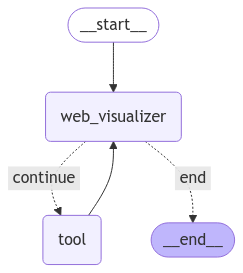

In [6]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

content='' additional_kwargs={'tool_calls': [{'id': 'call_kucNoCdNb8ejbw7j1ISCjBu3', 'function': {'arguments': '{"query":"NVIDIA stock price trend"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 177, 'total_tokens': 200, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-9b66278a-ca18-4c31-96b1-bd973b138a74-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'NVIDIA stock price trend'}, 'id': 'call_kucNoCdNb8ejbw7j1ISCjBu3', 'type': 'tool_call'}] usage_metadata={'input_tokens': 177, 'output_tokens': 23, 'total_tokens': 200, 'input_token_details': {'audio': 0, 'cache_read': 0},

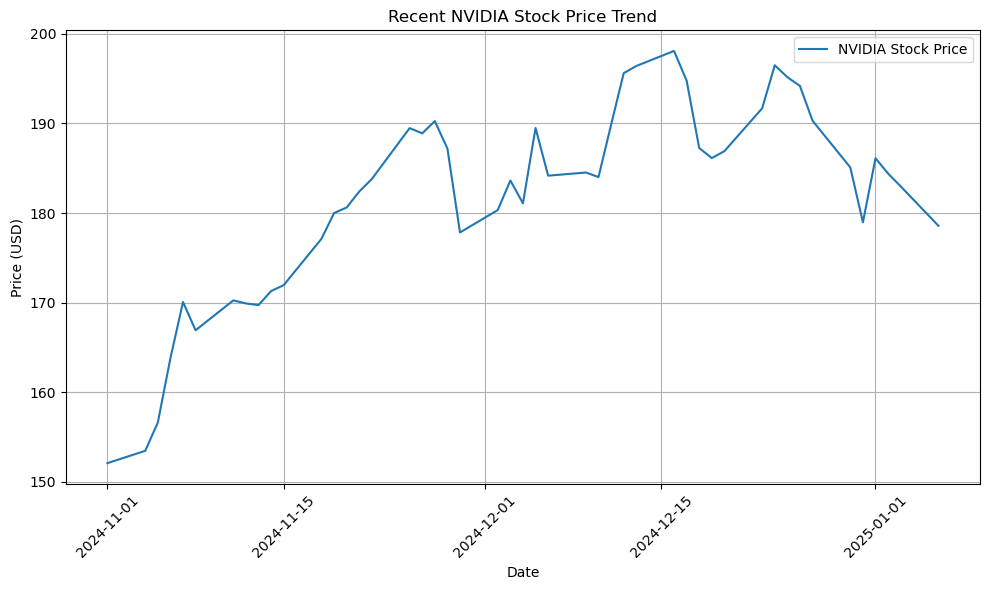

Receving update from node: 'tool
{'messages': [ToolMessage(content='Successfully executed: \n```python\nimport matplotlib.pyplot as plt\nimport pandas as pd\nimport numpy as np\n\ndates = pd.date_range(start="2024-11-01", end="2025-01-06", freq=\'B\')  # Business days\nnp.random.seed(0)\nprice_changes = np.random.normal(loc=0.001, scale=0.02, size=len(dates))  # Simulated daily returns\nprice = 146.76  # Starting price as of November 14, 2024\nprices = price * (1 + price_changes).cumprod()\n\nplt.figure(figsize=(10, 6))\nplt.plot(dates, prices, label=\'NVIDIA Stock Price\')\nplt.title(\'Recent NVIDIA Stock Price Trend\')\nplt.xlabel(\'Date\')\nplt.ylabel(\'Price (USD)\')\nplt.grid(True)\nplt.legend()\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.savefig(\'./charts/nvidia_stock_trend.png\')\nplt.show()\n```Stdout: \n\nIf you have completed all tasks, repond with FINAL ANSWER.', name='python_repl', id='3f840c3a-ab85-4ce9-9f86-1b0b69ff58c2', tool_call_id='call_rjyBeccLCOhwRCBCe7MKOBBN

In [13]:
initial_input = {'question' : "최근 엔비디아 주가 추세를 조사해서 시각화 해줘"}
thread = {"configurable" : {"thread_id" : "2"}}

for chunk in app.stream(initial_input, thread, stream_mode="updates"): # update 된 state 값만 가져옴져옴
    for node, values in chunk.items():
        print(f"Receving update from node: '{node}")
        print(values)
        print("\n\n")

### 3-4. Inner Visualizer

In [18]:
from finpilot.inner_visualizer import inner_visualizer_node

In [5]:
workflow = StateGraph(State)

workflow.add_node("inner_visualizer", inner_visualizer_node)

workflow.add_edge(START, "inner_visualizer")
workflow.add_edge("inner_visualizer", END)

app = workflow.compile()

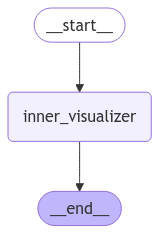

In [6]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))



> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import pandas as pd\n\ndf = pd.read_csv('c:/SKN05-FINAL-3TEAM/model/data/stock_data.csv')\n\ndf['Date'] = pd.to_datetime(df['Date'])\n\n# Define the COVID-19 period as starting from March 2020 to December 2021\ncovid_start = pd.to_datetime('2020-03-01')\ncovid_end = pd.to_datetime('2021-12-31')\n\n# Split the data into COVID and non-COVID periods\ncovid_period = df[(df['Date'] >= covid_start) & (df['Date'] <= covid_end)]\nnon_covid_period = df[(df['Date'] < covid_start) | (df['Date'] > covid_end)]\n\n# Exclude Nasdaq and calculate descriptive statistics for each period\ncovid_stats = covid_period.drop(columns=['Nasdaq']).describe()\nnon_covid_stats = non_covid_period.drop(columns=['Nasdaq']).describe()\n\ncovid_stats, non_covid_stats"}`


(                                Date        TSLA        RIVN       GOOGL  \
count                            465  465.000000

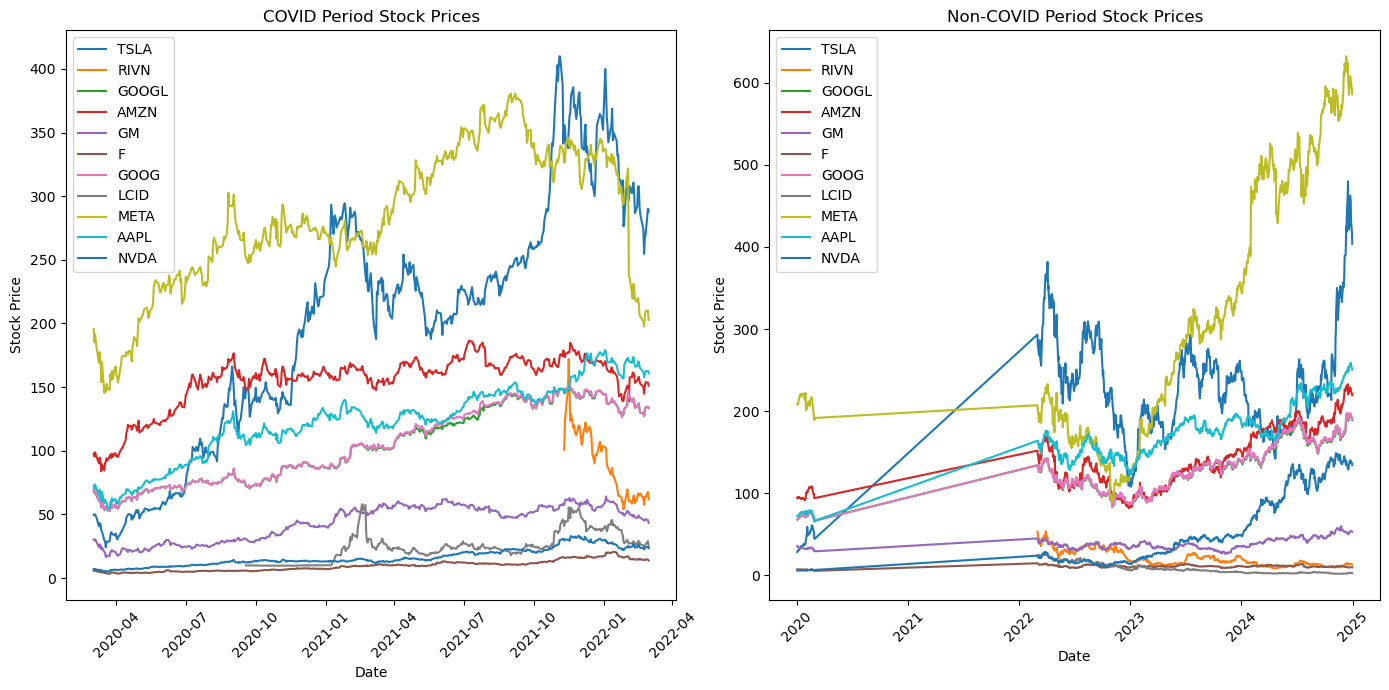

COVID 시기와 비-COVID 시기의 주가 데이터를 시각화하여 `./charts/stock_prices_covid_vs_non_covid.png`에 저장했습니다.

> Finished chain.
COVID-19 시기와 비COVID-19 시기의 주가 데이터를 비교하여 다음과 같은 통계적 차이를 발견할 수 있습니다. 이 분석에서는 NASDAQ을 제외하고 TSLA, RIVN, GOOGL, AMZN, GM, F, GOOG, LCID, META, AAPL, NVDA 주식의 통계 데이터를 사용했습니다.

### COVID-19 시기 (2020-03 ~ 2021-12)
- **TSLA**: 평균 주가는 약 189.73, 최대 주가는 409.97.
- **GOOGL**: 평균 주가는 약 100.96, 최대 주가는 149.30.
- **AMZN**: 평균 주가는 약 155.06, 최대 주가는 186.57.
- **META**: 평균 주가는 약 282.33, 최대 주가는 380.73.
- **AAPL**: 평균 주가는 약 119.04, 최대 주가는 177.42.
- **NVDA**: 평균 주가는 약 15.37, 최대 주가는 33.32.

### 비COVID-19 시기
- **TSLA**: 평균 주가는 약 227.33, 최대 주가는 479.86.
- **GOOGL**: 평균 주가는 약 129.08, 최대 주가는 196.66.
- **AMZN**: 평균 주가는 약 141.82, 최대 주가는 232.93.
- **META**: 평균 주가는 약 311.11, 최대 주가는 632.17.
- **AAPL**: 평균 주가는 약 171.87, 최대 주가는 259.02.
- **NVDA**: 평균 주가는 약 51.98, 최대 주가는 148.87.

### 분석 결과
- COVID-19 시기 동안에는 TSLA, AMZN, GOOGL, META 등의 주식이 상당한 주가 상승을 보였습니다. 이는 기술 및 온라인 서비스 관련 기업들이 팬데믹 동안 강세를 보였기 때문일 수 있습니다.
- 비COVID

In [7]:
config = {"recursion_limit" : 30}
inputs = {'question' : '주어진 주가 데이터에서 NASDAQ을 제외하고 코로나 시기와 아닌 시기의 차이를 분석할 수 있도록 분석 및 시각화 해줘'}

for chunk in app.stream(inputs, config, stream_mode="updates"): # update 된 state 값만 가져옴져옴
    for node, values in chunk.items():
        print(f"Receving update from node: '{node}")
        print(values)
        print("\n\n")

## 4. Merge Process

In [124]:
from finpilot.router import route_question

In [112]:
workflow = StateGraph(State)

################################# Add Nodes #################################

## writer
workflow.add_node("retriever", retrieve_node)
workflow.add_node("filter_documents", filter_documents_node)
workflow.add_node("writer", write_node)
workflow.add_node("transform_query", transform_query_node)
workflow.add_node("web_search", web_search_node)

## text_magician
workflow.add_node("text_magician", text_magician_node)

## web_visualizer
workflow.add_node("web_visualizer", web_visualizer_node)
workflow.add_node("tool", tool_node)

## inner_visualizer
workflow.add_node("inner_visualizer", inner_visualizer_node)






################################# add edges #################################
## Route Question
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "writer" : "retriever",
        "text_magician" : "text_magician",
        "web_visualizer" : "web_visualizer",
        "inner_visualizer" : "inner_visualizer"
    }
)

# writer process
workflow.add_edge("retriever", "filter_documents")
workflow.add_conditional_edges(
    "filter_documents",
    decide_write_or_rewrite_query,
    {
        "writer" : "writer",
        "transform_query" : "transform_query"
    },
)
workflow.add_conditional_edges(
    "transform_query",
    decide_to_retrieve_or_web_search,
    {
        "retriever" : "retriever",
        "web_search" : "web_search"
    }
)
workflow.add_edge("web_search", "writer")
workflow.add_conditional_edges(
    "writer",
    decide_to_regenerate_or_rewrite_query_or_end,
    {
        "not supported" : "writer",
        "useful" : END,
        "not useful" : "transform_query"
    }
)

# text_magician process
workflow.add_edge("text_magician", END)


# web_visualizer process
workflow.add_conditional_edges(
    "web_visualizer",
    should_continue,
    {
        "continue" : "tool",
        "end" : END
    }
)
workflow.add_edge("tool", "web_visualizer")


# inner_visualizer process
workflow.add_edge("inner_visualizer", END)







################################# Compile Workflow #################################
app = workflow.compile()









################################# Visualize Application Architecture #################################
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

In [127]:
def invoke_app(question):
    inputs = {"question" : question}
    
    result = app.invoke(inputs)
    print(result['generation'])

In [128]:
invoke_app("코스피와 코스닥에 대한 최근 이슈에 대한 인사이트를 작성해줘")

[Graph Log] ROUTE QUESTION ...
[Graph Log] ROUTE QUESTION to 'writer'
[Graph Log] RETRIEVE ...
[Graph Log] FILTER DOCUMENTS ...
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Relevance Grader Log] GRADE : DOCUMENT RELEVANT
[Graph Log] DETERMINES 'WRITE' OR 'REWRITE QUESTION' ...
[Graph Log] DECISION : REWRITE QUESTION
[Graph Log] TRANSFORM QUERY ...
[Graph Log] DETERMINES 'RETRIEVE' OR 'WEB SEARCH' ...
[Graph Log] DECISION : WEB SEARCH
[Graph Log] WEB SEARCH ...
[Graph Log] WRITE ...
[Graph Log] CHECK HALLUCINATIONS ...
[Graph Log] DECISION : ANSWER IS GROUNDED IN DOCUMENTS
[Graph Log] CHECK ANSWER IS USEFUL OR NOT ...
[Graph Log] DECISION : GENERATION ADDRESSES QUESTION
최근 코스피는 외국인과 기관투자자의 매수로 2440선을 회복했으며, 현재 2444.70으로 1.91% 상승했습니다. 코스닥 지수는 장중 2% 상승하며 700선을 탈환하여 700.40을 기록하고 있습니다. 이러한 상승세에도 불구하고, 간밤 뉴욕증시는 약세로 마감했습니다.


In [129]:
question = """
    최근 한국의 주식 시장인 코스피는 외국인 투자자와 기관투자자들의 활발한 매수세 덕분에 2440선을 회복하며 2444.70에 도달했습니다. 이는 시장에 긍정적인 신호로 작용하며 투자자들의 신뢰를 높이고 있습니다. 외국인 투자자들은 특히 기술주와 대형주에 대한 매수세를 강화하고 있으며, 이는 한국 경제의 회복세와 글로벌 경제의 안정성을 반영하는 것으로 해석됩니다. 한편, 코스닥 지수는 장중 2% 상승하며 700선을 탈환했습니다. 코스닥은 중소형주와 기술주 중심으로 구성되어 있어, 이러한 상승세는 혁신 기업들의 성장 가능성에 대한 기대감을 더욱 부각시키고 있습니다. 특히 바이오, IT, 게임 관련 주식들이 강세를 보이며 투자자들의 관심을 끌고 있습니다. 전반적으로 국내 증시는 상승세를 보이고 있으며, 이는 글로벌 경제의 회복과 함께 한국 경제의 긍정적인 지표들이 반영된 결과로 볼 수 있습니다. 전문가들은 이러한 추세가 지속될 경우, 기업 실적 개선과 함께 주식 시장의 추가 상승 가능성도 높다고 전망하고 있습니다. 투자자들은 앞으로의 시장 흐름을 주의 깊게 살펴보며, 기회를 포착하기 위한 전략을 세우는 것이 중요할 것입니다
    
    이 텍스트를 요약해줘
"""

invoke_app(question)

[Graph Log] ROUTE QUESTION ...
[Graph Log] ROUTE QUESTION to 'text_magician'
[Graph Log] TEXT_MAGICIAN ...
최근 한국의 주식 시장인 코스피는 외국인 및 기관 투자자들의 활발한 매수 덕분에 2440선을 회복하며 2444.70에 도달했습니다. 이는 시장에 긍정적인 신호로 작용하고 있으며, 외국인 투자자들은 기술주와 대형주에 대한 매수세를 강화하고 있습니다. 코스닥 지수도 2% 상승하며 700선을 탈환했으며, 특히 바이오, IT, 게임 관련 주식들이 강세를 보이고 있습니다. 전반적으로 국내 증시는 상승세를 보이고 있으며, 전문가들은 이러한 추세가 지속될 경우 기업 실적 개선과 함께 추가 상승 가능성이 높다고 전망하고 있습니다. 투자자들은 앞으로의 시장 흐름을 주의 깊게 살펴보아야 할 것입니다.


In [130]:
question = """
    최근 한국의 주식 시장인 코스피가 외국인 및 기관투자자들의 활발한 매수세로 2440선을 회복하며 2444.70에 도달했습니다. 이는 시장에 긍정적인 신호로 작용하고 있으며, 외국인 투자자들은 기술주와 대형주에 대한 매수세를 강화하고 있습니다. 코스닥 지수도 2% 상승하며 700선을 탈환했으며, 바이오, IT, 게임 관련 주식들이 강세를 보이고 있습니다. 전반적으로 국내 증시는 상승세를 보이고 있으며, 전문가들은 이러한 추세가 지속될 경우 기업 실적 개선과 함께 추가 상승 가능성이 높다고 전망하고 있습니다. 투자자들은 시장 흐름을 주의 깊게 살펴보며 기회를 포착하기 위한 전략을 세우는 것이 중요합니다.
    
    이 텍스트를 확장해줘
"""

invoke_app(question)

[Graph Log] ROUTE QUESTION ...
[Graph Log] ROUTE QUESTION to 'text_magician'
[Graph Log] TEXT_MAGICIAN ...
최근 한국의 주식 시장인 코스피가 외국인 및 기관투자자들의 활발한 매수세로 2440선을 회복하며 2444.70에 도달했습니다. 이는 시장에 긍정적인 신호로 작용하고 있으며, 외국인 투자자들은 기술주와 대형주에 대한 매수세를 강화하고 있습니다. 특히, 삼성전자와 SK하이닉스와 같은 대형 기술주가 외국인 투자자들의 관심을 끌고 있으며, 이러한 흐름은 향후 기업 실적에 긍정적인 영향을 미칠 것으로 예상됩니다.

코스닥 지수도 2% 상승하며 700선을 탈환했습니다. 바이오, IT, 게임 관련 주식들이 강세를 보이고 있는 가운데, 특히 게임 산업은 글로벌 시장에서도 큰 주목을 받고 있습니다. 국내 게임 개발사들은 해외 진출을 확대하고 있으며, 이는 투자자들에게 매력적인 투자 기회를 제공하고 있습니다. 바이오 기업들도 신약 개발 및 임상 시험에서 긍정적인 결과를 발표하며 주가 상승을 이끌고 있습니다.

전반적으로 국내 증시는 상승세를 보이고 있으며, 전문가들은 이러한 추세가 지속될 경우 기업 실적 개선과 함께 추가 상승 가능성이 높다고 전망하고 있습니다. 특히, 글로벌 경제 회복과 함께 한국 경제의 성장 가능성이 높아지고 있다는 점에서 투자자들의 기대감이 커지고 있습니다. 

그러나 이러한 긍정적인 흐름 속에서도 투자자들은 신중함을 잃지 말아야 합니다. 시장의 변동성이 클 수 있으며, 외부 요인—예를 들어, 미국의 금리 정책 변화나 글로벌 경제 상황—이 한국 시장에 미치는 영향도 고려해야 합니다. 따라서 투자자들은 시장 흐름을 주의 깊게 살펴보며 기회를 포착하기 위한 전략을 세우는 것이 중요합니다. 

또한, 투자자들은 포트폴리오 다각화를 통해 리스크를 관리하고, 장기적인 관점에서의 투자 전략을 수립하는 것이 필요합니다. 최근의 상승세가 단기적인 현상인지 아니면 지속 가능한 성장으로

[Graph Log] ROUTE QUESTION ...
[Graph Log] ROUTE QUESTION to 'web_visualizer'


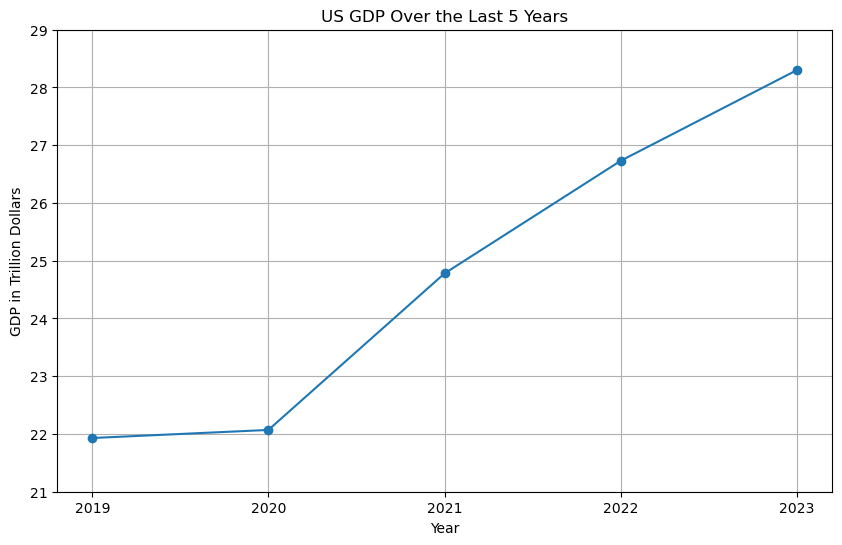

최근 5년 간 미국 GDP를 시각화한 결과는 다음과 같습니다:

- 2019년: $21.93 조
- 2020년: $22.07 조
- 2021년: $24.78 조
- 2022년: $26.73 조
- 2023년: $28.30 조

![US GDP Over the Last 5 Years](./charts/us_gdp_last_5_years.png)

이 그래프는 최근 5년 간 미국 GDP의 변화를 보여줍니다. 각 연도의 GDP는 조 단위로 측정되었습니다.


In [131]:
invoke_app("최근 5년 간 미국 GDP 를 조사해서 시각화해줘")